# Phương thức tự xây dựng  

## Ví dụ 1.  
(Dữ liệu tự tạo)

Dữ liệu tự tạo, dim=2, N=1500, C=3 class (0, 1, 2) mỗi lớp có 500 điểm.  
Dữ liệu phân bố sao cho có thể được tách tuyến tính cho dễ thực hành.  

B1. Khởi tạo dữ liệu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# randomly generate data
N = 500  # number of training sample
d = 2  # data dimension
C = 3  # number of classes (for c = 0, 1, 2)
means = [[2, 2], [8, 3], [3, 6]]  # centeroid of each class dataset
cov = [[1, 0], [0, 1]]
# generate 3 classes of datasets
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# each column is a datapoint (arrange 3 vectors X1 X2 X3 then transpose matrix)
X = np.concatenate((X0, X1, X2), axis=0).T
# extended data by add row ONES (equivalent to 1) at first place
X = np.concatenate((np.ones((1, 3 * N)), X), axis=0)

# Generate label for data points of each class (0, 1, 2)
# with first 500 will belong to class 0, second 500 => 1 and last 500=> class 2
original_label = np.asarray([0] * N + [1] * N + [2] * N).T  # this is Y - output

In [2]:
print('X =', X)
print('original_label =', original_label)

X = [[1.         1.         1.         ... 1.         1.         1.        ]
 [2.09230046 1.15694539 1.25830896 ... 3.0155302  1.61134161 2.56299552]
 [0.30286842 1.65423933 1.05431989 ... 6.17693775 4.18336279 6.63039575]]
original_label = [0 0 0 ... 2 2 2]


B2. Trực quan hóa dữ liệu

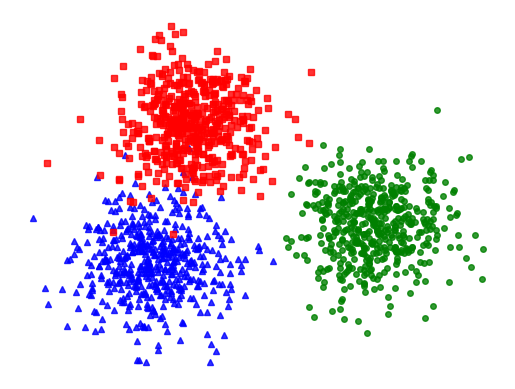

In [3]:
def display(X, label):
    X0 = X[:, label == 0]
    X1 = X[:, label == 1]
    X2 = X[:, label == 2]
    plt.plot(X0[0, :], X0[1, :], "b^", markersize=4, alpha=0.8)
    plt.plot(X1[0, :], X1[1, :], "go", markersize=4, alpha=0.8)
    plt.plot(X2[0, :], X2[1, :], "rs", markersize=4, alpha=0.8)
    plt.axis("off")
    plt.plot()
    plt.show()


display(X[1:, :], original_label)

B3. Hàm tự xây dựng phục vụ hồi quy logistic nhiều lớp

Viết hàm chuyển label Y sang dạng one-hot-coding  

In [4]:
from scipy import sparse

C=3
def convert_labels(y, C=C):
    """
    convert 1d label to a matrix label: each column of this
    matrix coresponding to 1 element in y. In i-th column of Y,
    only one non-zeros element located in the y[i]-th position,
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix(
        (np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))
    ).toarray()
    return Y


# Y = convert_labels(y, C)

Các hàm softmax, regression, cost, predict

In [5]:
def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.
    """
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = e_Z / e_Z.sum(axis=0)
    return A


def softmax(Z):
    """
    #Compute softmax values for each sets of scores in V.
    #each column of V is a set of score.
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis=0)
    return A


def softmax_regression(X, y, W_init, eta, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W


# cost or loss function
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y * np.log(A))


# Predict that X belong to which class (1..C now indexed as 0..C-1 )
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    # A = softmax_stable(W.dot(X.T))
    return np.argmax(A, axis=0)


# W[-1] is the solution, W is all history of weights

B4. Sử dụng các hàm tự xây dựng cho hồi quy và lấy ra hệ số

In [6]:
eta = .05  
d = X.shape[0] 
W_init = np.random.randn(X.shape[0], C) 
W = softmax_regression(X, original_label, W_init, eta) 
print(W[-1])

[[ 7.70308906 -4.34545188 -4.16536145]
 [-1.06709468  1.54459544 -0.90049346]
 [-0.75561971 -0.75214836  2.1191184 ]]


Kết quả thu được là có 3 hàm tương ứng với 3 đường thẳng phân chia 3 class

B5. Trực quan hóa kết quả hệ số thu được

(1, 270400)
(3, 270400)


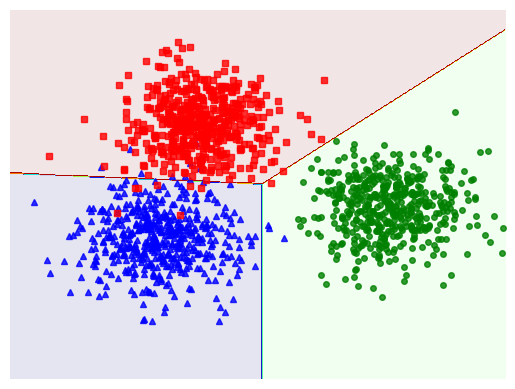

<Figure size 640x480 with 0 Axes>

In [7]:
# Visualize

xm = np.arange(-2, 11, 0.025)
xlen = len(xm)
ym = np.arange(-3, 10, 0.025)
ylen = len(ym)
xx, yy = np.meshgrid(xm, ym)

print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)

XX = np.concatenate((np.ones((1, xx.size)), xx1, yy1), axis=0)

print(XX.shape)

Z = pred(W[-1], XX)

Z = Z.reshape(xx.shape)

CS = plt.contourf(xx, yy, Z, 200, cmap="jet", alpha=0.1)

plt.xlim(-2, 11)
plt.ylim(-3, 10)
plt.xticks(())
plt.yticks(())

display(X[1:, :], original_label)
plt.savefig("ex1.png", bbox_inches="tight", dpi=300)
plt.show()

# Sử dụng thư viện (vẫn giống buổi trước - với phân loại logistic 2 class - thôi)

# Bài tập vận dụng

## Bài 1 (Ví dụ 2)  
(Dữ liệu: bộ dữ liệu hoa Iris)

Phân loại hoa Iris theo kích thước cánh và đài hoa:  
 - dim=4  
 - data_type:float  
 - N=150  
 - C=3 (setosa, versicolor, virginica)  
 - Mỗi lớp có 50 bản ghi  

B1. Nạp vào data và trực quan hóa  
Do X đầu vào có 4 chiều nên để trực quan được trên mặt phẳng 2D thì dùng PCR để giảm số chiều mà vẫn giữ mối quan hệ của 4 chiều ban đầu  

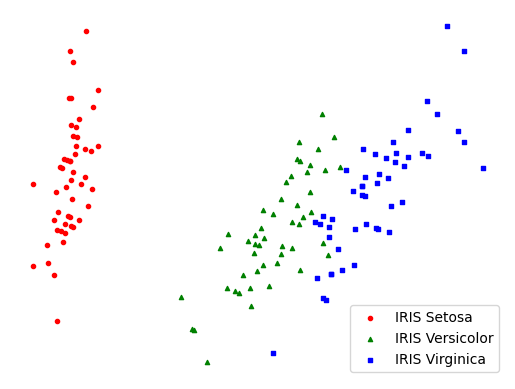

In [8]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :4]  # we take full 4 features
Y = iris.target

# Normalize data
X_norm = (X - X.min()) / (X.max() - X.min())

pca = sklearnPCA(n_components=2)  # 2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

plt.axis("off")

plt.scatter(
    transformed[Y == 0][0], transformed[Y == 0][1], s=9, label="IRIS Setosa", c="red"
)
plt.scatter(
    transformed[Y == 1][0],
    transformed[Y == 1][1],
    s=9,
    label="IRIS Versicolor",
    c="green",
    marker="^",
)
plt.scatter(
    transformed[Y == 2][0],
    transformed[Y == 2][1],
    s=9,
    label="IRIS Virginica",
    c="blue",
    marker="s",
)

plt.legend()

plt.show()

Cách 1. Sử dụng hàm tự xây dựng  

B1. Đọc vào dữ liệu và thêm chiều (1, 1, 1, ...) vào thành phần đầu của X để không triệt tiêu hệ số tự do 

In [9]:
print('X =', X[:3])
print('Y =', Y[:3])

X = [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
Y = [0 0 0]


In [10]:
print(X.shape, Y.shape)

(150, 4) (150,)


In [11]:
X = X.T
d = X.shape[0]  # d = 4
C = 3
N = X.shape[1]  # n = 150   
X = np.concatenate((np.ones((1, N)), X), axis=0)    # thêm chiều x0 = 1 vào để khi nhân với hệ số tự do không bị âm 

In [12]:
# X = X.T 
# Y = Y.T
# print('X =', X[:3])
# print('Y =', Y[:3])

B2. Sử dụng hàm tự xây dựng ở Ví dụ 1 để train và in ra hệ số mô hình

In [13]:
print(X.shape, Y.shape)

(5, 150) (150,)


In [14]:
# Split train and valid 4:1 -> 120:30
# Phân chia dữ liệu
n_samples = X.shape[1]
n_train = 120

# Tạo một mảng indices chứa các chỉ số của dữ liệu
indices = np.arange(n_samples)

# Trộn ngẫu nhiên các chỉ số
np.random.shuffle(indices)

# Lấy các chỉ số cho tập huấn luyện và tập validation
train_indices = indices[:n_train]
valid_indices = indices[n_train:]

# Tạo tập huấn luyện và tập validation từ các chỉ số đã chọn
X_train = X[:, train_indices]
Y_train = Y[train_indices]
X_valid = X[:, valid_indices]
Y_valid = Y[valid_indices]

# Kết quả
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", Y_train.shape)
print("Kích thước X_valid:", X_valid.shape)
print("Kích thước y_valid:", Y_valid.shape)


Kích thước X_train: (5, 120)
Kích thước y_train: (120,)
Kích thước X_valid: (5, 30)
Kích thước y_valid: (30,)


In [15]:
eta = .05  
W_init = np.random.randn(X_train.shape[0], C) 
W = softmax_regression(X_train, Y_train, W_init, eta) 
print(W[-1])

[[ 0.24460577  0.6175669  -2.30651391]
 [ 1.00708452  1.50528626 -4.15381519]
 [ 5.28930431  1.00530475 -3.68531022]
 [-5.41019134 -1.86516939  5.49508071]
 [-3.27510512 -3.18490264  7.06977502]]


In [16]:
print(np.array(W).shape)

(10081, 5, 3)


In [17]:
Y_pred = pred(np.array(W[-1]), X_valid)
print(Y_pred)
print(Y_valid)

[2 2 2 2 2 1 1 0 2 1 0 1 2 0 0 2 1 2 1 0 0 0 0 2 2 0 1 2 0 1]
[2 2 2 2 2 1 1 0 2 1 0 1 1 0 0 2 1 2 1 0 0 0 0 2 2 0 1 2 0 1]


In [18]:
# Tính các chỉ số độ chính xác bằng cách sử dụng từ hàm tự xây dựng
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Độ chính xác (Accuracy)
accuracy = accuracy_score(Y_valid, Y_pred)

# Precision, Recall và F1-score
precision = precision_score(Y_valid, Y_pred, average='weighted')
recall = recall_score(Y_valid, Y_pred, average='weighted')
f1 = f1_score(Y_valid, Y_pred, average='weighted')

# In các chỉ số
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9666666666666667
Precision: 0.9694444444444444
Recall: 0.9666666666666667
F1-score: 0.9664109121909632


Nhận xét: Accuracy của cách dùng hàm tự xây dựng khá tốt (0.86) nhưng vẫn kém của hàm có sẵn từ thư viện (0.96)

Cách 2. Sử dụng thư viện  
Cụ thể ta dùng LogisticRegression trong sklearn.linear_model

In [19]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
 
import sklearn 
#from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.datasets import load_iris 
 
iris=load_iris() 
# print(iris) 
X=iris.data # Observed variable  
Y=iris.target # Dependent variable (label) 
 
#print(X.shape) 
#print(Y.shape) 
 
# Splitting Train and test Data 
X_train,X_test,Y_train,Y_test=sklearn.model_selection.train_test_split(X,Y,test_size=0.2,  
         random_state=2) 
#sc=StandardScaler() 
#X_train=sc.fit_transform(X_train) 
#X_test=sc.transform(X_test) 
 
# Call to Logistic Regression Model - SAG: solving is based on Stochastic Average Gradient 
lorg=LogisticRegression(multi_class='multinomial',solver='sag', max_iter=5000) 
# and train model by Training Dataset 
lorg.fit(X_train,Y_train)  
 
# Then Predict the Test data 
Y_pred=lorg.predict(X_test) 
 
# for accuracy 
from sklearn.metrics import accuracy_score 
print(accuracy_score(Y_test,Y_pred)) 
 
# for confusion matrix 
from sklearn.metrics import confusion_matrix 
cm=confusion_matrix(Y_test,Y_pred) 
print(cm)

0.9666666666666667
[[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]


Kết luận từ ví dụ mẫu dùng thư viện ở trên:  
Có thể sử dụng thư viện trong trường hợp phân loại nhiều lớp (>=3) tương tự như với phân loại 2 class.  
Cụ thể các bước là:  
 - B1. Load dữ liệu (tùy theo việc dữ liệu dạng gì và ở đâu)  
 - B2. Gán dữ liệu cho biến quan sát X và biến dự báo Y  
 - B3. Chia tập training và tập test nếu cần. Chú ý trường hợp dữ liệu do chúng ta tự tạo thì cần tự gán tập dữ liệu test (không có nhãn)  
 - B4. Tạo đối tượng LogisticRegression  của gói sklearn.linear_model  (đã khai báo từ thư viện scikit-learn)  
 - B5. Tiến hành “huấn luyện” trên tập dữ liệu training để tìm hệ số tối ưu thông qua phương thức fit của đối tượng nói trên: <LogisticRegression object>.fit(X_train, Y_train)  
 - B6. Nếu có dữ liệu test, tiến hành dự đoán cho bộ dữ liệu test với mô hình và bộ tham số đã được tối ưu theo dữ liệu huấn luyện: Y_predict = <LogisticRegression object>.predict(X_test)  
 - B7. Hiển thị kết quả/đánh giá độ chính xác/tính confusion matrix

## Bài 2 (Ví dụ 3)  

Phân chia tập dữ liệu các đoạn văn bản lấy từ các bản tin tổng hợp.  
Bộ dữ liệu 20000 bản tin ngắn thuộc đồng đều 20 lĩnh vực trong 6 nhóm khác nhau.  
Dữ liệu được sử dụng trong ví dụ này đã được tiền xử lý (theo kỹ thuật Bag-Of-Words để giảm độ khó) -> tức dữ liệu dạng vector như trước.  

B1. Import data và phân chia train test  
Dữ liệu này có sẵn trong thư viện nên ta import

In [20]:
from sklearn.datasets import fetch_20newsgroups_vectorized
n_samples = 20000 
# n_samples = 200

X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True) 
X = X[:n_samples] 
y = y[:n_samples] 

In [21]:
# print(X[:1])
print(y[:5])

[17  7 10 10  7]


In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.1) 
import sklearn 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=2) 
train_samples, n_features = X_train.shape 
n_classes = np.unique(y).shape[0]

print("Number of training samples:", train_samples)
print("Number of features:", n_features)
print("Number of classes:", n_classes)

Number of training samples: 15076
Number of features: 130107
Number of classes: 20


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Build logistic regression model
model = LogisticRegression(multi_class='multinomial',solver='sag', max_iter=5000) 
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
# for accuracy 
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test,y_pred)) 
 
# for confusion matrix 
from sklearn.metrics import confusion_matrix 
cm=confusion_matrix(y_test,y_pred) 
print(cm)

0.8188328912466843
[[121   2   0   0   1   1   0   1   2   0   0   0   0   0   1  16   0   4
    1   4]
 [  0 157  16   3   4   8   5   0   0   0   1   1   3   0   1   1   0   2
    0   0]
 [  1   9 144  16   4   8   3   0   1   1   0   1   0   2   0   1   0   0
    0   0]
 [  0  12  14 136  11   5   3   3   0   0   0   0   5   3   0   0   1   0
    0   0]
 [  1   2   3  14 139   2   7   0   1   0   0   1   9   2   0   0   1   0
    1   0]
 [  0  10   8   5   2 176   1   0   0   0   1   1   0   0   3   0   0   0
    0   0]
 [  0   2   4   9   2   0 169   6   0   2   1   1   5   1   1   1   1   0
    1   0]
 [  0   1   0   0   0   2   5 164   5   0   3   0   7   4   1   0   0   1
    1   0]
 [  1   0   1   2   0   1   3   8 158   0   0   0   0   3   1   0   0   0
    1   1]
 [  1   2   0   0   1   1   3   2   0 179   6   1   3   1   1   2   0   0
    1   1]
 [  3   1   0   0   0   2   2   1   1   3 195   0   1   0   0   1   0   0
    1   1]
 [  2   4   0   0   2   2   0   1   0   0   0 

Ban đầu để có 200 mẫu thì độ chính xác chỉ là 0.2 tuy nhiên để là 20000 mẫu thì độ chính xác đã tăng tới 0.8

## Bài 3 (Ví dụ 4)  

Phân loại các loại kính.  
Database:  
 - N=214 mẫu kính đặc trưng bởi 9 thông số kỹ thuật (RI, Na, Mg, Al, Si, K, Ca, Ba, Fe)  
 - dim=11 cột (Id, 9 cột thuộc tính X, 1 cột Y)  
 - C=7 class (có 7 loại kính)  


In [24]:
from matplotlib import pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# change file_data to where did you put it!
file_data = "data/glass.csv"

glass_df = pd.read_csv(file_data)
print(glass_df.info())

glass_types = glass_df["Type"].unique()
print(glass_types)

print(glass_df["Type"].value_counts())

X_1 = glass_df[glass_df.columns[:-1]]
y_1 = glass_df["Type"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id_Number  214 non-null    int64  
 1   RI         214 non-null    float64
 2   Na         214 non-null    float64
 3   Mg         214 non-null    float64
 4   Al         214 non-null    float64
 5   Si         214 non-null    float64
 6   K          214 non-null    float64
 7   Ca         214 non-null    float64
 8   Ba         214 non-null    float64
 9   Fe         214 non-null    float64
 10  Type       214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB
None
[1 2 3 5 6 7]
Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


In [25]:
X_1 = glass_df.drop(columns=['Id_Number', 'Type'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.25, random_state=42
)

In [26]:
print(X_1.shape, y_1.shape)

(214, 9) (214,)


In [27]:
print(X_train[:3])
print(y_train[:3])
print(X_test[:3])
print(y_test[:3])

          RI     Na    Mg    Al     Si     K    Ca    Ba    Fe
29   1.51784  13.08  3.49  1.28  72.86  0.60  8.49  0.00  0.00
19   1.51735  13.02  3.54  1.69  72.73  0.54  8.44  0.00  0.07
185  1.51131  13.69  3.20  1.81  72.81  1.76  5.43  1.19  0.00
29     1
19     1
185    7
Name: Type, dtype: int64
          RI     Na    Mg    Al     Si     K    Ca    Ba    Fe
9    1.51755  13.00  3.60  1.36  72.99  0.57  8.40  0.00  0.11
197  1.51727  14.70  0.00  2.34  73.28  0.00  8.95  0.66  0.00
66   1.52152  13.05  3.65  0.87  72.22  0.19  9.85  0.00  0.17
9      1
197    7
66     1
Name: Type, dtype: int64


In [28]:
print(X_train.shape, y_train.shape)

(160, 9) (160,)


In [29]:
from sklearn.linear_model import LogisticRegression

# Call to Logistic Regression Model - SAG: solving is based on Stochastic Average Gradient 
lorg = LogisticRegression(multi_class='multinomial',solver='sag', max_iter=5000) 
# and train model by Training Dataset 
lorg.fit(X_train, y_train)  
 
# Then Predict the Test data 
y_pred = lorg.predict(X_test) 
 
# for accuracy 
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test, y_pred)) 
 
# for confusion matrix 
from sklearn.metrics import confusion_matrix 
cm=confusion_matrix(y_test, y_pred) 
print(cm)

0.7037037037037037
[[12  2  0  0  0  0]
 [ 4 16  0  0  1  0]
 [ 2  2  0  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  1  0  0  0  2]
 [ 0  0  0  0  0  8]]


## Bài 4 (Ví dụ 5)  
Phân loại các chữ số viết tay

### Sử dụng hàm tự xây dựng để train theo Logistic Regression & không dùng giảm số chiều & không dùng thư viện

Đọc dữ liệu ảnh và nạp vào thành ma trận số.  
Dưới đây ta import đường dẫn.  

In [1]:
import os
import numpy as np
# set names to the paths because they're too long
data_path = 'data/number_writing'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

Xây dựng phương thức đọc dữ liệu từ tệp gzip, giải nén và đưa về định dạng là một dãy ảnh (một dãy ma trận nguyên)

In [2]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip
    # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

Sử dụng hàm đọc và nạp dữ liệu để nạp vào chương trình: 5000 ảnh training và 10000 ảnh test

In [3]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

/tmp/ipykernel_11465/1956505741.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


Dưới đây là các hàm để thực hiện logistic regression bằng việc tự xây dựng hàm 

In [4]:
# Convert matrix to image
def get_image(image):
    return image.reshape(28, 28)


# These methods are from Vi du 1
def convert_labels(y, C):
    from scipy import sparse

    Y = sparse.coo_matrix(
        (np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))
    ).toarray()
    return Y


def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis=0)
    return A


def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = e_Z / e_Z.sum(axis=0)
    return A


def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

Đoạn chương trình chứa thủ tục tính toán theo phương pháp lặp Gradient Descent ngẫu nhiên trong mô hình hồi quy logistic cho dữ liệu nhiều lớp.

In [5]:
def _softmax_regression(
    X, Y, theta, lambda_=0.5, iterations=20, learning_rate=1e-5, batch_size=200
):
    from sklearn.metrics import log_loss

    losses = []
    _theta = theta
    d, N = X.shape
    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")
    return _theta, losses

Nhìn qua về dữ liệu

0 7


<Figure size 640x480 with 0 Axes>

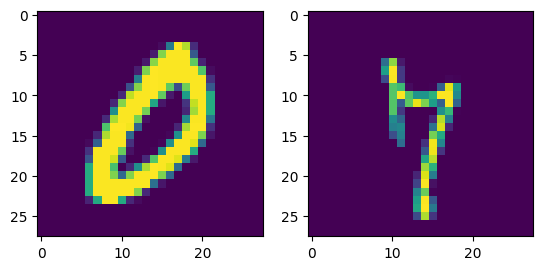

In [6]:
# for display and test digit :D
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])
train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()
plt.figure()
# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

Phân chia train & test set

(785, 5000)
(10, 5000)


<Figure size 640x480 with 0 Axes>

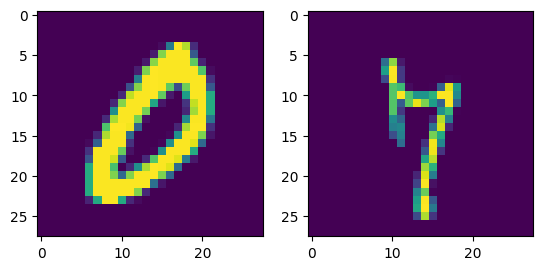

In [7]:
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T), axis = 0)
Y_train = convert_labels(train_labels, 10)
print(X_train.shape)
print(Y_train.shape)
train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()
plt.figure()
# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

Chạy quá trình training và in ra loss function

In [8]:
theta = np.zeros((X_train.shape[0], 10))
opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

epoch 0 - cost 0.7953360205168455
epoch 1 - cost 0.7860685451991728
epoch 2 - cost 0.7838086391460415
epoch 3 - cost 0.7836973419235046
epoch 4 - cost 0.7800733465027067
epoch 5 - cost 0.7769532171145196
epoch 6 - cost 0.7742333792407193
epoch 7 - cost 0.7779708305511797
epoch 8 - cost 0.7783718752287526
epoch 9 - cost 0.7789325478371569
epoch 10 - cost 0.7772695433727185
epoch 11 - cost 0.7752462682319848
epoch 12 - cost 0.7776045989595708
epoch 13 - cost 0.7775414496442252
epoch 14 - cost 0.7746866001916209
epoch 15 - cost 0.7729079123487451
epoch 16 - cost 0.7753933923141813
epoch 17 - cost 0.7772955719826353
epoch 18 - cost 0.7749020159537706
epoch 19 - cost 0.7749499962423169
training success:  (785, 10) 500


Tính các thông số về độ chính xác (gọi thư viện để chương trình không quá dài)

In [9]:
from sklearn.metrics import accuracy_score
print('accuracy training data: ', accuracy_score(train_labels, pred(opt_theta, X_train)))
# test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 1000, _is=False, shuffle=False)
X_test = np.concatenate((np.ones((1, test_images.shape[0])), test_images.T), axis = 0)
print(X_test.shape)
print('accuracy testing data: ', accuracy_score(test_labels, pred(opt_theta, X_test)))

accuracy training data:  0.9532
(785, 10000)
accuracy testing data:  0.8819


### Dùng đoạn code chọn số chiều chính ở trên (ví dụ 2), đưa tập dữ liệu đã có về 2 chiều sau đó hiển thị màn hình mối quan hệ giữa các lớp dữ liệu  

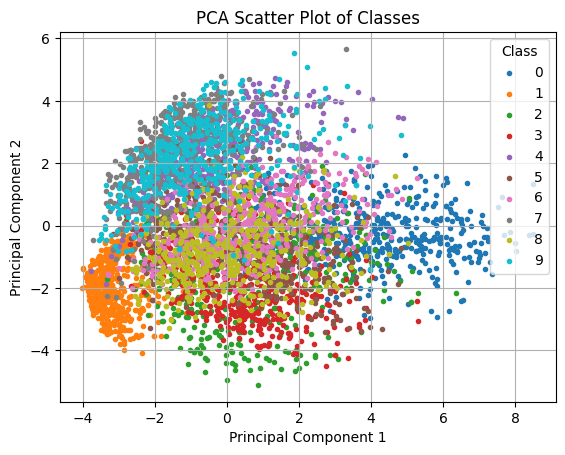

In [10]:
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Normalize data
X_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())

# Perform PCA
pca = sklearnPCA(n_components=2)  # 2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm.T))

# Convert DataFrame to numpy array
transformed_array = transformed.to_numpy()

# Get labels
Y_labels = np.argmax(Y_train.T, axis=1)

# Set up plot
# plt.figure(figsize=(10, 8))

# Scatter plot with different colors for each class
for i in range(10):  # Assuming you have 10 classes
    indices = np.where(Y_labels == i)[0]
    plt.scatter(
        transformed_array[indices, 0], 
        transformed_array[indices, 1], 
        s=9, 
        label=str(i)
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of Classes')
plt.legend(title='Class')
plt.grid(True)
plt.show()


### Với dữ liệu đã có, chạy lại ví dụ với các thư viện của gói linear_model, lớp LogisticRegression và so sánh kết quả

In [11]:
from sklearn.linear_model import LogisticRegression

lorg = LogisticRegression(multi_class="multinomial", solver="sag", max_iter=5000)

Y_labels_train = np.argmax(Y_train.T, axis=1)

# and train model by Training Dataset
lorg.fit(X_train.T, train_labels)   # train_labels <=> Y_labels_train

In [ ]:
# Then Predict the Test data
Y_pred = lorg.predict(X_test.T)

# for accuracy
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, Y_pred))

# for confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, Y_pred)
print(cm)